### np-bragg-biocars-spectrum
This is just np-bragg-sparse with an inferred spectrum from BioCARS precognition processing. 


Populating the interactive namespace from numpy and matplotlib


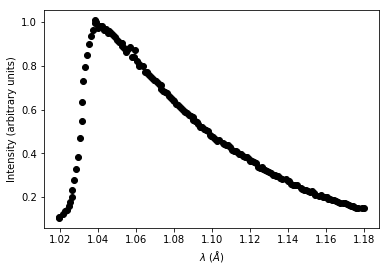

In [51]:
%pylab inline
import tensorflow as tf
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
from scipy.stats import special_ortho_group
import pandas as pd

floattype=np.float16
pixels = 2000 #number of pixels on each axis
pixelsize = .1 #mm
hmax = 50
maxres = 2.0 #Detector edge
Rs = 0.001
half_boxsize = 25 #How many pixels around each reflection to calculate scattering

#Spectral properties of the beam
spectrum = pd.read_csv('Xray-spectrum.txt', delim_whitespace=True)
wavelengths = spectrum['Wavelength'].values.astype(np.float16)
weights     = spectrum['Intensity'].values.astype(np.float16)
plt.plot(wavelengths, weights, 'ko')
plt.xlabel("$\lambda\ (\AA)$")
plt.ylabel("Intensity (arbitrary units)")


detector_distance = maxres*pixels*pixelsize/2/wavelengths.min()

detector_ori = np.array([
    -pixels*pixelsize/2,
    -pixels*pixelsize/2,
    detector_distance,
], dtype=floattype)
fast_axis = np.array([1, 0, 0], dtype=floattype)
slow_axis = np.array([0, 1, 0], dtype=floattype)

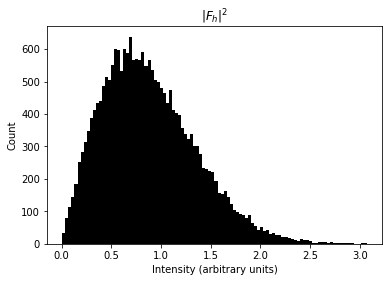

In [52]:
A = np.array([
    [30., 0., 0.],
    [ 0.,40., 0.],
    [ 0., 0.,90.],
], dtype=floattype)

A = np.matmul(special_ortho_group.rvs(3), A)


#Laue index generator
def generate_indices(lmin, lmax, hmax, A):
    """
    PARAMETERS
    ----------
    lmin : float
        minimum wavelengthin the laue spectrum
    lmax : float
        maximum wavelengthin the laue spectrum
    hmax : int
        largest index to generate
    A : array-like
        real space lattice basis
    """
    H = None
    row = np.arange(-hmax, hmax + 1)
    for h in row:
        tmpvar = np.array(np.meshgrid(np.arange(-hmax, hmax, dtype=np.int8), 
                                 np.arange(-hmax, hmax, dtype=np.int8), 
                                 h)).reshape((3, (2*hmax)**2))
        Rh = np.matmul(tmpvar.T, np.linalg.inv(A)) + [0 , 0, 1/lmax]
        Dh = np.linalg.norm(Rh, 2, 1)
        indices = (Dh > 1/wavelengths.max()) 

        Rh = np.matmul(tmpvar.T, np.linalg.inv(A)) + [0 , 0, 1/lmin]
        Dh = np.linalg.norm(Rh, 2, 1)
        indices = indices & (Dh < 1/wavelengths.min())
        indices = np.where(indices)[0]
        tmpvar = tmpvar[:,indices]
        
        Rh = np.matmul(tmpvar.T, np.linalg.inv(A)) + [0 , 0, 1/lmin]
        tmpvar = tmpvar[:,Rh[:,2] > 0.] #Only consider forward scatter

        if H is not None:
            H = np.hstack((H, tmpvar))
        else:
            H = tmpvar.copy()
    return H

H = generate_indices(wavelengths.min(), wavelengths.max(), hmax, A)

#Structure factor amplitude squared distribution
#For now we can just make this a random draw from 
# a Rayleigh distribution

I = np.sqrt(-np.log(np.random.random(len(H.T))))
plt.figure()
plt.hist(I, 100, color='k')
plt.title("$|F_h|^2$")
plt.xlabel("Intensity (arbitrary units)")
plt.ylabel("Count")

dtypes = {
    'H': np.int8,
    'K': np.int8,
    'L': np.int8,
    'I': np.float16,
}

I_df = pd.DataFrame(np.hstack((H.T, I[:,None])), columns=['H','K','L','I']).astype(dtypes).set_index(['H', 'K', 'L'])

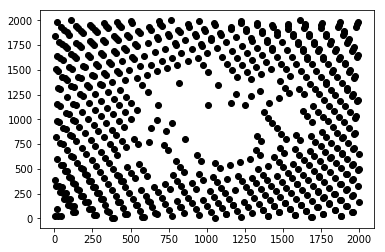

In [53]:
def Rh2Detector(Rh, detector_ori, fast_axis, slow_axis):
    """
    PARAMETERS
    ----------
    Rh : array
        n x 3 array of reciprocal lattice coordinates
    ori : array
        3D array with the detector origin's coordinates
    fast_axis : array
        3-vector with the detector fast axis direction
    slow_axis : array
        3-vector with the detector slow axis direction
    """
    linear_systems = np.dstack((
        -Rh, 
        np.ones(Rh.shape)*fast_axis[None, :], 
        np.ones(Rh.shape)*slow_axis[None, :])).swapaxes(-1, -2)
    pixpos = np.matmul(-detector_ori, np.linalg.inv(linear_systems))/pixelsize
    return pixpos[:,1:]

Rh = np.matmul(H.T, np.linalg.inv(A)) + [0 , 0, 1/wavelengths.mean()]
pixpos = Rh2Detector(Rh, detector_ori, fast_axis, slow_axis)
x,y = pixpos[np.all(pixpos >= 0, 1) & np.all(pixpos < pixels, 1)].T
plt.plot(x, y, 'ko')

In [54]:
P = np.array(np.meshgrid(
    np.arange(pixels, dtype=floattype),
    np.arange(pixels, dtype=floattype)
))
detector_basis = np.vstack((fast_axis, slow_axis))
Rp = np.matmul(P.T, pixelsize*detector_basis) + detector_ori
box = np.array(np.meshgrid(
    np.arange(-half_boxsize, half_boxsize+1), 
    np.arange(-half_boxsize, half_boxsize+1), )
).reshape((2, (1+2*half_boxsize)**2))


image = np.zeros((pixels, pixels))
for i in tqdm(range(len(wavelengths))):
    wavelength, weight = wavelengths[i], weights[i]
    Rh = np.matmul(H.T, np.linalg.inv(A)) + [0 , 0, 1/wavelength]
    pixpos = Rh2Detector(Rh, detector_ori, fast_axis, slow_axis)
    Hindex = np.all(pixpos >= 0, 1) & np.all(pixpos < pixels-half_boxsize-1, 1)
    I_sel = I_df.loc[list(map(tuple, H[:,Hindex].T)),].values.T[0]
    Rh = Rh[Hindex]
    pixpos = pixpos[Hindex]
    idx = np.round(pixpos).astype(int)[:,:,None] + box[None,:,:]

    S1 = (Rp/np.linalg.norm(Rp, 2, 2)[:,:,None]/wavelength)
    image[idx[:,0,:], idx[:,1,:]] += I_sel[:,None] * (weight*np.exp(-np.square(np.linalg.norm(S1[idx[:,0,:], idx[:,1,:]] - Rh[:,None,:], 2, -1)/Rs)))

(-0.5, 1999.5, 1999.5, -0.5)

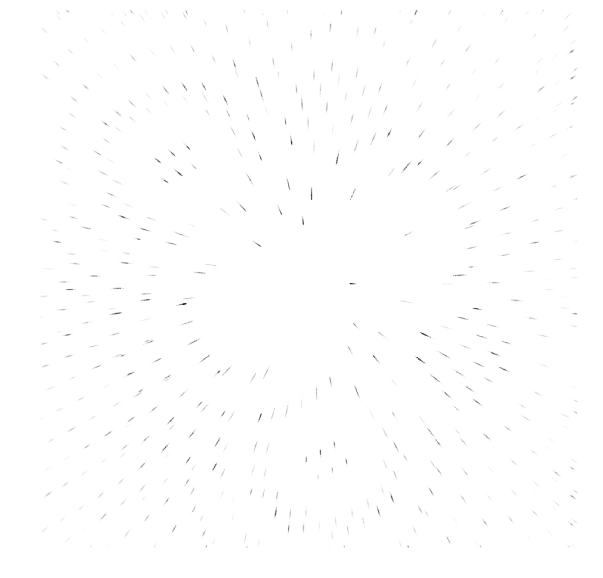

In [55]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(np.log(1+image), cmap='Greys')
plt.axis('off')